In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
%matplotlib inline

In [2]:
t_titre = 35
t_label = 25
fig_width= 15

In [3]:
observer = 'LB'
mode = 'enregistrement'
from aSPEM import Analysis
e = Analysis()#observer=observer, mode=mode)

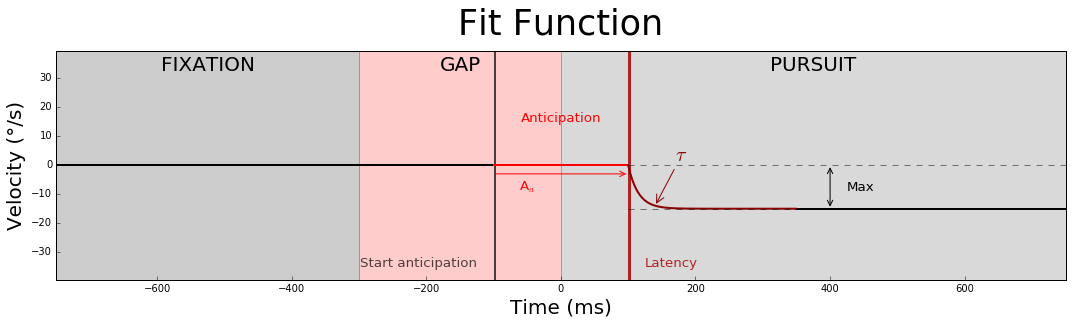

In [4]:
fig, axs= e.plot_Fit()

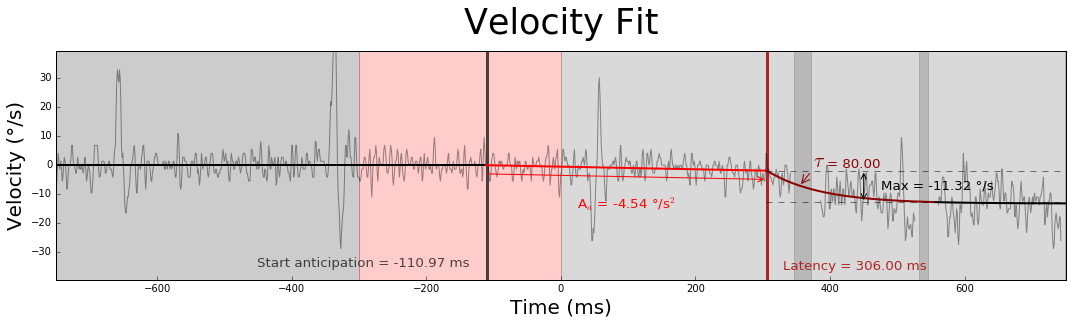

In [5]:
fig, axs = e.plot_Fit(plot='velocity')

/usr/local/lib/python3.5/dist-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


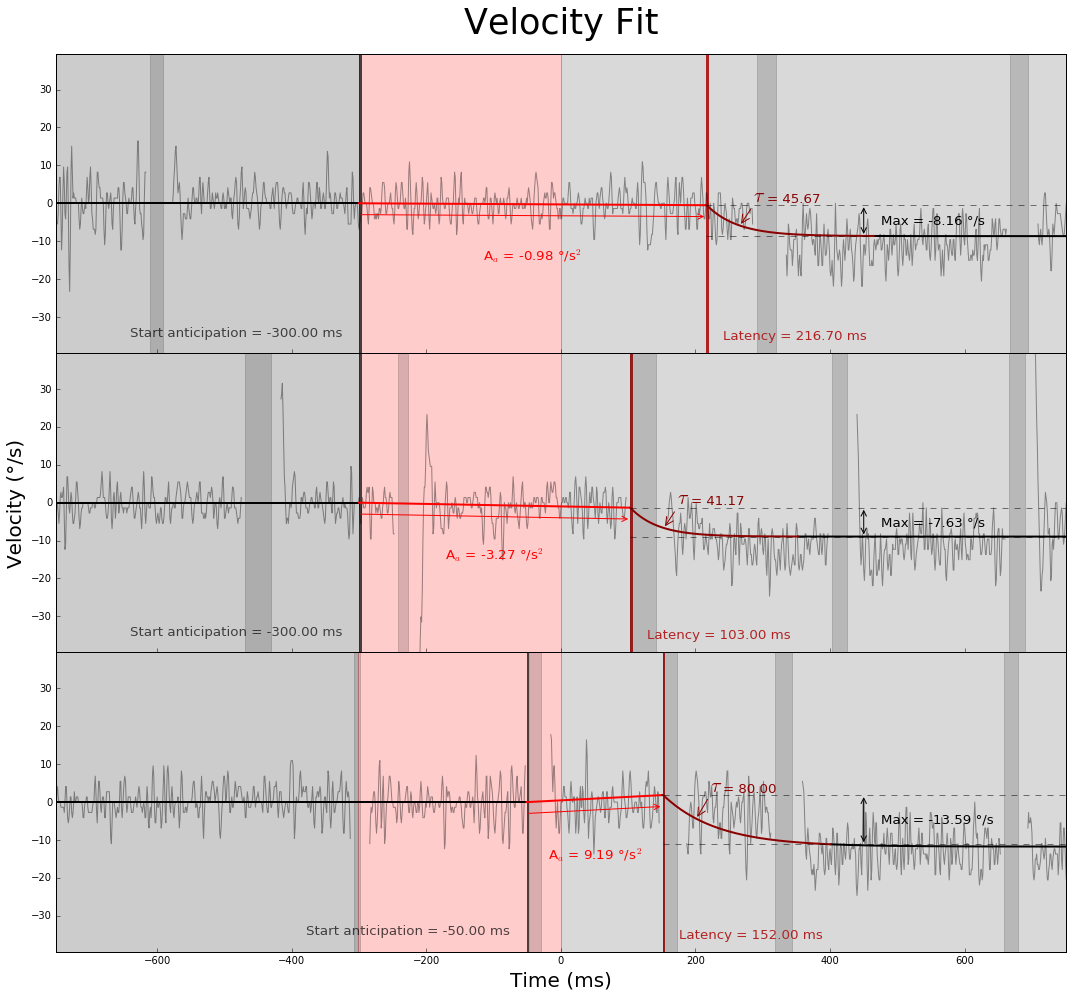

In [6]:
fig, axs, result = e.plot_Fit(plot='velocity', report=True, trials=[19,71,83])

In [7]:
for x in range(len(result)) :
    print('essai',x ,'\n', result[0])

essai 0 
 [[Model]]
    Model(exponentiel)
[[Fit Statistics]]
    # function evals   = 217
    # data points      = 1583
    # variables        = 5
    chi-square         = 33744.832
    reduced chi-square = 21.385
    Akaike info crit   = 4853.197
    Bayesian info crit = 4880.033
[[Variables]]
    tau:          45.6722870 +/- 14.33977 (31.40%) (init= 15)
    maxi:         8.15561336 +/- 0.462715 (5.67%) (init= 15)
    latence:      1048.70487 +/- 8.421555 (0.80%) (init= 932)
    start_anti:   532.000787 +/- 135.2205 (25.42%) (init= 732)
    v_anti:      -0.98393491 +/- 1.366679 (138.90%) (init=-0)
    bino:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(start_anti, v_anti)        = -0.866 
    C(maxi, v_anti)              =  0.761 
    C(tau, latence)              = -0.698 
    C(maxi, start_anti)          = -0.439 
    C(maxi, latence)             = -0.310 
    C(latence, v_anti)           = -0.234 
    C(tau, maxi)                 =  0.172 
    C(la

### Fit

In [8]:
# pour générer les paramètre fit ainsi que les figures de tout les essais
#e.Fit()